In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import sympy as sym
from scipy.optimize import curve_fit

import jax
import jax.numpy as jnp
from jax import jit, config

import qiskit
from qiskit.quantum_info import Statevector, DensityMatrix
from qiskit import pulse
from qiskit_dynamics import Solver, DynamicsBackend
from qiskit_dynamics.pulse import InstructionToSignals
from qiskit_dynamics.array import Array

config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")
Array.set_default_backend("jax")

IBMQ.load_account()

/Users/chatt07/Desktop/sheldonian_env/lib/python3.9/site-packages/qiskit_dynamics/dispatch/backends/jax.py:34: UserWarning: The functionality in the perturbation module of Qiskit Dynamics requires a JAX version <= 0.4.6, due to a bug in JAX versions > 0.4.6. For versions 0.4.4, 0.4.5, and 0.4.6, using the perturbation module functionality requires setting os.environ['JAX_JIT_PJIT_API_MERGE'] = '0' before importing JAX or Dynamics.
  warnings.warn(
/var/folders/g4/_yhz0jm50s17zz2ms7wwytcr0000gr/T/ipykernel_22169/577377549.py:22: DeprecationWarning: The package qiskit.providers.ibmq is being deprecated. Please see https://ibm.biz/provider_migration_guide to get instructions on how to migrate to qiskit-ibm-provider (https://github.com/Qiskit/qiskit-ibm-provider) and qiskit-ibm-runtime (https://github.com/Qiskit/qiskit-ibm-runtime).
  IBMQ.load_account()
/var/folders/g4/_yhz0jm50s17zz2ms7wwytcr0000gr/T/ipykernel_22169/577377549.py:22: DeprecationWarning: The qiskit.IBMQ entrypoint and the 

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [2]:
provider = IBMQ.get_provider(hub="ibm-q-nus", group="default", project="default")

backend = provider.get_backend(
    "ibm_cairo"
)  # replace the name with the exact one for the backend that is desired from the previous displayed backends

backend_config = backend.configuration()

for key, value in backend_config.to_dict().items():
    print(key)
    print(value)

assert backend_config.open_pulse, "Backend doesn't support Pulse"
# Verifies whether Pulse is supported

dt = backend_config.dt  # Example way of getting data on the backend
print(
    f"Sampling time: {dt * 1e9} ns"
)  # The configuration returns dt in seconds, so multiply by
# 1e9 to get nanoseconds
backend_defaults = backend.defaults()

backend.configuration().timing_constraints

acquire_alignment = backend.configuration().timing_constraints["acquire_alignment"]
granularity = backend.configuration().timing_constraints["granularity"]
pulse_alignment = backend.configuration().timing_constraints["pulse_alignment"]

lcm = np.lcm(acquire_alignment, pulse_alignment)
print(f"Least common multiple of acquire_alignment and pulse_alignment: {lcm}")

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc.)
GHz = 1.0e9  # Gigahertz
MHz = 1.0e6  # Megahertz
us = 1.0e-6  # Microseconds
ns = 1.0e-9  # Nanoseconds

# Experiments will be run on these qubits
qubit_0 = 0
qubit_1 = 1

# The sweep will be centered around the estimated qubit frequency.
center_frequency_Hz_0 = backend_defaults.qubit_freq_est[qubit_0]
center_frequency_Hz_1 = backend_defaults.qubit_freq_est[qubit_1]

meas_freq_0 = backend_defaults.meas_freq_est[qubit_0]
meas_freq_1 = backend_defaults.meas_freq_est[qubit_1]

print(
    f"Qubit {qubit_0} has an estimated frequency of {center_frequency_Hz_0 / GHz} GHz."
)
print(
    f"Qubit {qubit_1} has an estimated frequency of {center_frequency_Hz_1 / GHz} GHz."
)

print(
    f"Resonator for qubit {qubit_0} has an estimated frequency of {meas_freq_0 / GHz} GHz."
)
print(
    f"Resonator for qubit {qubit_1} has an estimated frequency of {meas_freq_1 / GHz} GHz."
)

# scale factor to remove factors of 10 from the data
scale_factor = 1e-7


def get_closest_multiple_of(value, base_number):
    return int(value + base_number / 2) - (int(value + base_number / 2) % base_number)


# samples need to be multiples of 16
def get_closest_multiple_of_16(num):
    return get_closest_multiple_of(num, granularity)


# Convert seconds to dt
def get_dt_from(sec):
    return get_closest_multiple_of(sec / dt, lcm)


def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)

    return fitparams, y_fit


# exponential function
def exponential(t, tau, a, offset):
    return a * np.exp(-t / tau) + offset


# fit an exponential function
def fit_exponential(ts, values):
    p0 = [np.average(ts), 1, 0]
    return curve_fit(exponential, ts, values, p0=p0)


qubit = qubit_0
qubit_b = qubit_1

instruction_schedule_map = backend.defaults().instruction_schedule_map
measure_instructions = np.array(
    instruction_schedule_map.get("measure", qubits=[qubit]).instructions
)
measure_pulse = measure_instructions[-2, 1].pulse
measure_delay = measure_instructions[-1, 1]

x_instructions = np.array(
    instruction_schedule_map.get("x", qubits=[qubit]).instructions
)
x_pulse = x_instructions[0, 1].pulse

sx_instructions = np.array(
    instruction_schedule_map.get("sx", qubits=[qubit]).instructions
)
sx_pulse = sx_instructions[0, 1].pulse

cx_instructions = instruction_schedule_map.get("cx", qubits=[qubit_0, qubit_1])

print(f"measurement pulse: {measure_pulse}")
print(f"measurement delay: {measure_delay}")
print(f"x pulse: {x_pulse}")
print(f"sx pulse: {sx_pulse}")

backend_name
ibm_cairo
backend_version
1.3.5
n_qubits
27
basis_gates
['id', 'rz', 'sx', 'x', 'cx', 'reset']
gates
[{'name': 'id', 'parameters': [], 'qasm_def': 'gate id q { U(0, 0, 0) q; }', 'coupling_map': [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19], [20], [21], [22], [23], [24], [25], [26]]}, {'name': 'rz', 'parameters': ['theta'], 'qasm_def': 'gate rz(theta) q { U(0, 0, theta) q; }', 'coupling_map': [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19], [20], [21], [22], [23], [24], [25], [26]]}, {'name': 'sx', 'parameters': [], 'qasm_def': 'gate sx q { U(pi/2, 3*pi/2, pi/2) q; }', 'coupling_map': [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19], [20], [21], [22], [23], [24], [25], [26]]}, {'name': 'x', 'parameters': [], 'qasm_def': 'gate x q { U(pi, 0, pi) q; }', 'coupling_map': [[0], [1], [2], [3], [4

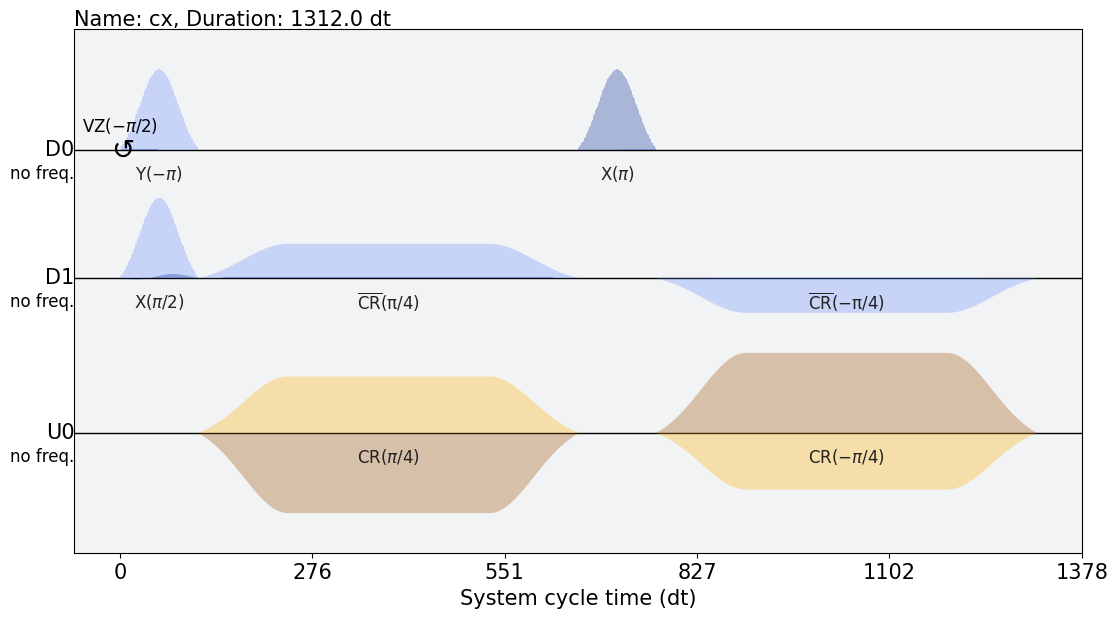

In [3]:
cx_instructions.draw()

In [4]:
# Helper function that returns a lifted Gaussian symbolic equation.
def lifted_gaussian(
    t: sym.Symbol,
    center,
    t_zero,
    sigma,
) -> sym.Expr:
    t_shifted = (t - center).expand()
    t_offset = (t_zero - center).expand()

    gauss = sym.exp(-((t_shifted / sigma) ** 2) / 2)
    offset = sym.exp(-((t_offset / sigma) ** 2) / 2)

    return (gauss - offset) / (1 - offset)

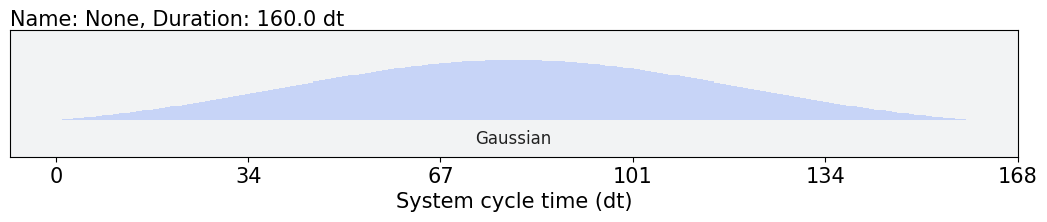

In [5]:
# Defining the General Lifted Gaussian Waveform

_t, _duration, _amp, _sigma, _angle = sym.symbols("t, duration, amp, sigma, angle")
_center = _duration / 2

envelope_expr = (
    _amp * sym.exp(sym.I * _angle) * lifted_gaussian(_t, _center, _duration + 1, _sigma)
)

dummy_pulse = pulse.ScalableSymbolicPulse(
    pulse_type="Gaussian",
    duration=160,
    amp=0.3,
    angle=0,
    parameters={"sigma": 40},
    envelope=envelope_expr,
    constraints=_sigma > 0,
    valid_amp_conditions=sym.Abs(_amp) <= 1.0,
)

dummy_pulse.draw()

In [6]:
# Constructing the Hamiltonian

dim = 3

v0 = 4.86e9
anharm0 = -0.32e9
r0 = 0.22e9

v1 = 4.97e9
anharm1 = -0.32e9
r1 = 0.26e9

J = 0.002e9

a = np.diag(np.sqrt(np.arange(1, dim)), 1)
adag = np.diag(np.sqrt(np.arange(1, dim)), -1)
N = np.diag(np.arange(dim))

ident = np.eye(dim, dtype=complex)
full_ident = np.eye(dim**2, dtype=complex)

N0 = np.kron(ident, N)
N1 = np.kron(N, ident)

a0 = np.kron(ident, a)
a1 = np.kron(a, ident)

a0dag = np.kron(ident, adag)
a1dag = np.kron(adag, ident)

static_ham0 = 2 * np.pi * v0 * N0 + np.pi * anharm0 * N0 * (N0 - full_ident)
static_ham1 = 2 * np.pi * v1 * N1 + np.pi * anharm1 * N1 * (N1 - full_ident)

static_ham_full = (
    static_ham0 + static_ham1 + 2 * np.pi * J * ((a0 + a0dag) @ (a1 + a1dag))
)

drive_op0 = 2 * np.pi * r0 * (a0 + a0dag)
drive_op1 = 2 * np.pi * r1 * (a1 + a1dag)

In [7]:
# Building the Solver

dt = 1 / 4.5e9
rtol = 1e-5
atol = 1e-3

y0 = Array(Statevector(np.array([1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0])))
t_linspace = np.linspace(0.0, 400 * 1e-9, 21)

dict_freqs = {"d0": v0, "d1": v1, "u0": v1, "u1": v0}
channels = {"d0", "d1", "u0", "u1"}

solver = Solver(
    static_hamiltonian=static_ham_full,
    hamiltonian_operators=[drive_op0, drive_op1, drive_op1, drive_op0],
    rotating_frame=static_ham_full,
    hamiltonian_channels=channels,
    channel_carrier_freqs=dict_freqs,
    dt=dt,
    evaluation_mode="dense",
)

In [13]:
# Schedules to Samples Function


def get_samples(params):
    amp, angle = params

    custom_pulse = pulse.ScalableSymbolicPulse(
        pulse_type="Gaussian",
        duration=160,
        amp=amp,
        angle=angle,
        parameters={"sigma": 40},
        envelope=envelope_expr,
        constraints=_sigma > 0,
        valid_amp_conditions=sym.Abs(_amp) <= 1.0,
    )

    custom_pulse_1 = pulse.ScalableSymbolicPulse(
        pulse_type="Gaussian",
        duration=160,
        amp=amp,
        angle=angle + 0.5 * np.pi,
        parameters={"sigma": 40},
        envelope=envelope_expr,
        constraints=_sigma > 0,
        valid_amp_conditions=sym.Abs(_amp) <= 1.0,
    )

    custom_pulse_2 = pulse.ScalableSymbolicPulse(
        pulse_type="Gaussian",
        duration=160,
        amp=amp,
        angle=angle + np.pi,
        parameters={"sigma": 40},
        envelope=envelope_expr,
        constraints=_sigma > 0,
        valid_amp_conditions=sym.Abs(_amp) <= 1.0,
    )

    custom_pulse_3 = pulse.ScalableSymbolicPulse(
        pulse_type="Gaussian",
        duration=160,
        amp=amp,
        angle=angle + 1.5 * np.pi,
        parameters={"sigma": 40},
        envelope=envelope_expr,
        constraints=_sigma > 0,
        valid_amp_conditions=sym.Abs(_amp) <= 1.0,
    )

    with pulse.build(
        default_alignment="sequential", name="Custom Schedule"
    ) as custom_sched:
        d0 = pulse.DriveChannel(0)
        d1 = pulse.DriveChannel(1)
        u0 = pulse.ControlChannel(0)
        u1 = pulse.ControlChannel(1)

        pulse.play(custom_pulse, d0)
        pulse.play(x_pulse, d0)
        pulse.delay(64, d0)
        pulse.play(custom_pulse_1, d1)
        pulse.play(sx_pulse, d1)
        pulse.delay(64, d1)
        pulse.play(custom_pulse_2, u0)
        pulse.delay(64, u0)
        pulse.play(custom_pulse_3, u1)
        pulse.delay(64, u1)
        pulse.call(cx_instructions)

    converter = InstructionToSignals(dt=dt, carriers=dict_freqs, channels=channels)
    signals = converter.get_signals(custom_sched)

    data = jnp.array(
        [
            signals[0].samples.data,
            signals[1].samples.data,
            signals[2].samples.data,
            signals[3].samples.data,
        ]
    )

    return data


p0 = jnp.array([0.1, 0.2])
fast_samples = jit(get_samples)
# fast_samples = get_samples
sig = fast_samples(p0)
print(f"Signals Shape: {sig.shape}")

Signals Shape: (4, 2432)


Channels aren't Mapped in an Elementary Manner!


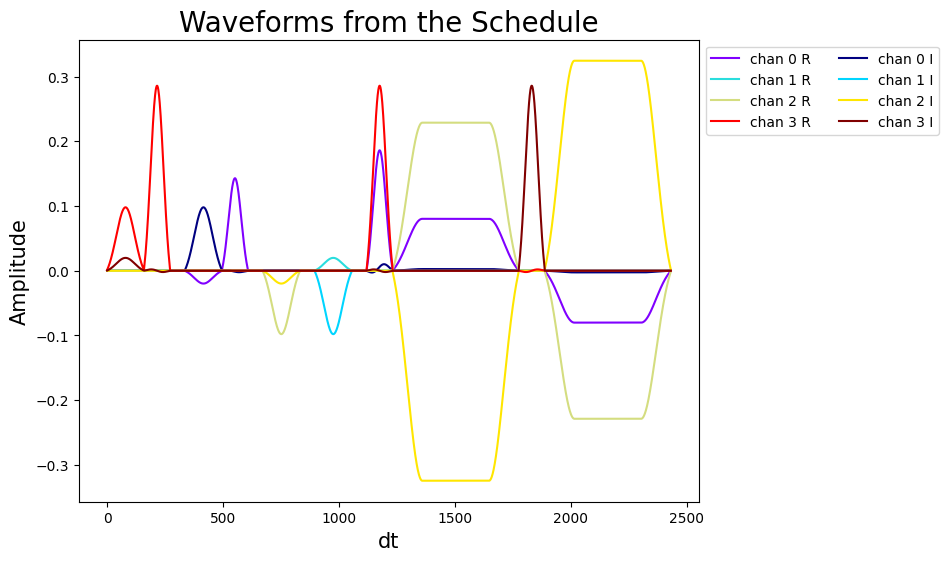

In [14]:
fig = plt.figure(figsize=(8.0, 6.0))

x = np.arange(len(sig))
ys = [i + x + (i * x) ** 2 for i in range(len(sig))]
colors_real = cm.rainbow(np.linspace(0, 1, len(ys)))
colors_imag = cm.jet(np.linspace(0, 1, len(ys)))

for i, [signal, cr, ci] in enumerate(zip(sig, colors_real, colors_imag)):
    plt.plot(signal.real, label=f"chan {i} R", color=cr)
    plt.plot(signal.imag, label=f"chan {i} I", color=ci)

print("Channels aren't Mapped in an Elementary Manner!")
handles, labels = plt.gca().get_legend_handles_labels()
order = np.concatenate((np.arange(len(ys)) * 2, np.arange(len(ys)) * 2 + 1))
plt.legend(
    [handles[idx] for idx in order],
    [labels[idx] for idx in order],
    bbox_to_anchor=(1.0, 1.0),
    ncol=2,
)
plt.xlabel("dt", fontsize=15)
plt.ylabel("Amplitude", fontsize=15)
plt.title("Waveforms from the Schedule", fontsize=20)
plt.show()

In [15]:
%timeit fast_samples(p0)

44.2 µs ± 6.18 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
